
# Version 1 — IndoBERT Sentiment (No EDA): End-to-End Process

## Process Overview
1) **Install Dependencies** — Clean install (remove RAPIDS/dask/gcsfs), pin `pyarrow`, install NLP libs.
2) **Mount Google Drive & Set Paths** — Connect to Drive and confirm input/output locations.
3) **Configure Hyperparameters** — Define model, columns, seeds, and training settings.
4) **Load CSV & Encode Labels** — Load dataset, clean text, and create label mappings.
5) **Stratified Train/Val/Test Split (80/10/10)** — Keep label balance across splits.
6) **Tokenize & Build Datasets** — Tokenize text with IndoBERT tokenizer and create HF datasets.
7) **Fine-Tune with Trainer** — Train IndoBERT, select best checkpoint by Macro-F1.
8) **Evaluate & Export Artifacts** — Test metrics, classification report, confusion matrix, saved model.
9) **Batch Inference Helper** — Predict labels for new texts in batches.


In [ ]:
# === Process 1: Clean Install (remove RAPIDS/dask/gcsfs; pin pyarrow; install NLP deps) ===
# This project doesn't use RAPIDS/dask/gcsfs. We remove them to avoid resolver conflicts.

# 1) Remove RAPIDS & friends + conflicting IO libs
!pip uninstall -y cudf-cu12 pylibcudf-cu12 dask-cudf-cu12 cuml-cu12 cudf-polars-cu12
!pip uninstall -y rapids cudf dask distributed gcsfs fsspec pyarrow

# 2) Reinstall a stable pyarrow compatible with many stacks
!pip install -q "pyarrow==19.0.0"

# 3) Install NLP dependencies
# Update transformers to a version that supports `evaluation_strategy`
!pip install -q "datasets" "transformers>=4.30.0" accelerate scikit-learn matplotlib sentencepiece

# 4) Satisfy IPython's optional dependency if present
!pip install -q jedi

# 5) Sanity check
!pip check

Found existing installation: fsspec 2024.6.1
Uninstalling fsspec-2024.6.1:
  Successfully uninstalled fsspec-2024.6.1
Found existing installation: pyarrow 19.0.0
Uninstalling pyarrow-19.0.0:
  Successfully uninstalled pyarrow-19.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.21.0 requires fsspec[http]<=2024.6.1,>=2023.1.0, which is not installed.
bigframes 2.24.0 requires fsspec>=2023.3.0, which is not installed.
bigframes 2.24.0 requires gcsfs!=2025.5.0,>=2023.3.0, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.24.0 requires gcsfs!=2025.5.0,>=2023.3.0, which is not installed.
bigframes 2.24.0 requires gcsfs, which is not installed.
rapids-dask-dependency 25.6.0 requires dask, which i

In [ ]:

# === Process 2: Mount Google Drive & Paths ===
# Remarks: Set the exact DATA_PATH and OUTPUT_DIR as requested; ensure output folder exists.
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path

DATA_PATH = "/content/drive/MyDrive/Proyek/Data/tweet.csv"
OUTPUT_DIR = Path("/content/drive/MyDrive/Proyek/Sentiment_IndoBERT")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_PATH:", DATA_PATH)
print("OUTPUT_DIR:", OUTPUT_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATA_PATH: /content/drive/MyDrive/Proyek/Data/tweet.csv
OUTPUT_DIR: /content/drive/MyDrive/Proyek/Sentiment_IndoBERT


In [ ]:

# === Process 3: Configure Hyperparameters ===
MODEL_NAME = "indobenchmark/indobert-base-p1"
TEXT_COL   = "tweet"
LABEL_COL  = "sentimen"

MAX_LEN    = 128
BATCH_SIZE = 16
EPOCHS     = 3
LR         = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.06
SEED       = 42

import random, numpy as np, torch
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [ ]:

# === Process 4: Load CSV & Encode Labels ===
import pandas as pd

df = pd.read_csv(DATA_PATH)
if TEXT_COL not in df.columns or LABEL_COL not in df.columns:
    raise ValueError(f"CSV must include columns: '{TEXT_COL}' and '{LABEL_COL}'")

df = df[[TEXT_COL, LABEL_COL]].dropna().reset_index(drop=True)
df[TEXT_COL] = df[TEXT_COL].astype(str).str.replace("\s+", " ", regex=True).str.strip()

unique_labels = sorted(df[LABEL_COL].astype(str).unique().tolist())
label2id = {lbl: i for i, lbl in enumerate(unique_labels)}
id2label = {i: lbl for lbl, i in label2id.items()}
df["label_id"] = df[LABEL_COL].astype(str).map(label2id)

print("Label mapping:", label2id)
df.head(3)


<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3692865682.py:9: SyntaxWarning: invalid escape sequence '\s'
  df[TEXT_COL] = df[TEXT_COL].astype(str).str.replace("\s+", " ", regex=True).str.strip()


Label mapping: {'negatif': 0, 'netral': 1, 'positif': 2}


,tweet,sentimen,label_id
0,Kata @prabowo Indonesia tidak dihargai bangsa ...,negatif,0
1,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",netral,1
2,"Di era Jokowi, ekonomi Indonesia semakin baik....",netral,1


In [ ]:

# === Process 5: Stratified Train/Val/Test Split ===
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df["label_id"]
)
df_val, df_test = train_test_split(
    df_temp, test_size=0.5, random_state=SEED, stratify=df_temp["label_id"]
)

len(df_train), len(df_val), len(df_test)


(1452, 181, 182)

In [ ]:
from huggingface_hub import notebook_login
from google.colab import userdata
userdata.get('HF_TOKEN')

# Login to Hugging Face Hub using the token stored in Colab secrets
notebook_login()

In [ ]:

# === Process 6: Tokenize & Build Datasets ===
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=MAX_LEN,
        padding=False
    )

train_ds = Dataset.from_pandas(pd.DataFrame({
    "text": df_train[TEXT_COL].tolist(),
    "labels": df_train["label_id"].tolist()
}))
val_ds = Dataset.from_pandas(pd.DataFrame({
    "text": df_val[TEXT_COL].tolist(),
    "labels": df_val["label_id"].tolist()
}))
test_ds = Dataset.from_pandas(pd.DataFrame({
    "text": df_test[TEXT_COL].tolist(),
    "labels": df_test["label_id"].tolist()
}))

train_ds = train_ds.map(tokenize_batch, batched=True, remove_columns=["text"])
val_ds   = val_ds.map(tokenize_batch,   batched=True, remove_columns=["text"])
test_ds  = test_ds.map(tokenize_batch,  batched=True, remove_columns=["text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_ds.set_format(type="torch")
val_ds.set_format(type="torch")
test_ds.set_format(type="torch")


Map:   0%|          | 0/1452 [00:00<?, ? examples/s]

Map:   0%|          | 0/181 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

In [ ]:
# === Process 7: Fine-Tune with Trainer ===
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

num_labels = len(label2id)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label={i: id2label[i] for i in range(num_labels)},
    label2id={k: v for k, v in label2id.items()},
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    return {
        "accuracy": acc,
        "precision_macro": p,
        "recall_macro": r,
        "f1_macro": f1
    }

use_bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8

args = TrainingArguments(
    output_dir=str(OUTPUT_DIR / "hf_runs"),
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    warmup_ratio=WARMUP_RATIO,
    seed=SEED,
    logging_steps=20,
    save_total_limit=2,
    report_to="none",
    fp16=(not use_bf16),
    bf16=use_bf16,
    optim="adamw_torch"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1609758125.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.816800,0.756442,0.690608,0.698958,0.691166,0.687851
2,0.619700,0.700882,0.707182,0.712276,0.707195,0.707955
3,0.434600,0.767326,0.696133,0.696284,0.696266,0.696044


TrainOutput(global_step=273, training_loss=0.664407518757132, metrics={'train_runtime': 110.699, 'train_samples_per_second': 39.35, 'train_steps_per_second': 2.466, 'total_flos': 190712005234128.0, 'train_loss': 0.664407518757132, 'epoch': 3.0})

Test metrics: {'test_loss': 0.7915655374526978, 'test_accuracy': 0.6428571428571429, 'test_precision_macro': 0.6473743415276559, 'test_recall_macro': 0.6436868664234688, 'test_f1_macro': 0.6428571428571429, 'test_runtime': 1.0529, 'test_samples_per_second': 172.85, 'test_steps_per_second': 11.397}
              precision    recall  f1-score   support

     negatif     0.6269    0.7119    0.6667        59
      netral     0.7059    0.5902    0.6429        61
     positif     0.6094    0.6290    0.6190        62

    accuracy                         0.6429       182
   macro avg     0.6474    0.6437    0.6429       182
weighted avg     0.6474    0.6429    0.6425       182



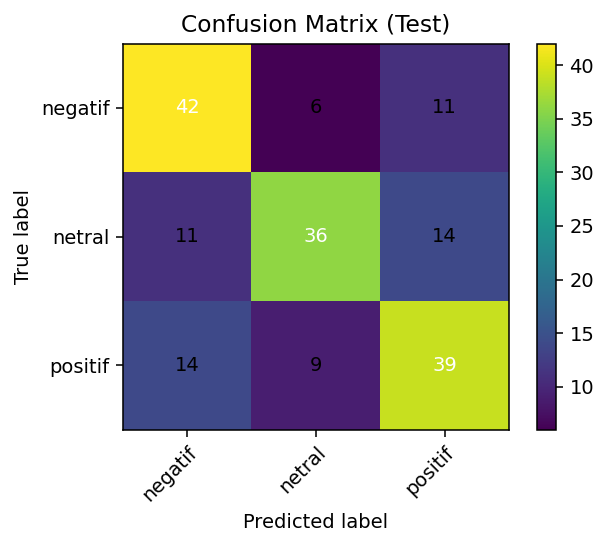

Saved to: /content/drive/MyDrive/Proyek/Sentiment_IndoBERT


In [ ]:

# === Process 8: Evaluate & Export Artifacts ===
import json
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

pred = trainer.predict(test_ds)
test_metrics = {k: float(v) for k, v in pred.metrics.items()}
print("Test metrics:", test_metrics)

y_true = np.array(test_ds["labels"])
y_pred = pred.predictions.argmax(axis=-1)

target_names = [id2label[i] for i in range(num_labels)]
report_txt = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report_txt)

best_dir = OUTPUT_DIR / "best_model"
best_dir.mkdir(parents=True, exist_ok=True)
trainer.save_model(str(best_dir))
tokenizer.save_pretrained(str(best_dir))

with open(OUTPUT_DIR / "label_maps.json", "w", encoding="utf-8") as f:
    json.dump({"label2id": label2id, "id2label": id2label}, f, ensure_ascii=False, indent=2)

with open(OUTPUT_DIR / "test_metrics.json", "w", encoding="utf-8") as f:
    json.dump(test_metrics, f, ensure_ascii=False, indent=2)

with open(OUTPUT_DIR / "classification_report.txt", "w", encoding="utf-8") as f:
    f.write(report_txt)

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_labels)))
fig, ax = plt.subplots(figsize=(5, 4), dpi=140)
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(num_labels),
    yticks=np.arange(num_labels),
    xticklabels=target_names,
    yticklabels=target_names,
    ylabel="True label",
    xlabel="Predicted label",
    title="Confusion Matrix (Test)"
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

cm_path = OUTPUT_DIR / "confusion_matrix_test.png"
plt.savefig(cm_path, bbox_inches="tight")
plt.show()

print("Saved to:", OUTPUT_DIR)


In [ ]:
# === Process 9: Batch Inference Helper ===
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import DataCollatorWithPadding

def tokenize_inference_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=MAX_LEN,
        padding=True  # Enable padding for inference
    )

def predict_texts(texts, batch_size=64):
    model = trainer.model.eval()
    ds = Dataset.from_dict({"text": texts})
    ds = ds.map(tokenize_inference_batch, batched=True, remove_columns=["text"]) # Use the new tokenization function
    ds.set_format(type="torch")
    loader = DataLoader(ds, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer))
    all_preds = []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(model.device) for k, v in batch.items()}
            logits = model(**batch).logits
            preds = torch.argmax(logits, dim=-1).cpu().tolist()
            all_preds.extend(preds)
    return [id2label[p] for p in all_preds]

# Quick demo
predict_texts([
    "Pelayanannya sangat memuaskan, terima kasih!",
    "Biasa saja sih, tidak terlalu istimewa.",
    "Sangat buruk, saya kecewa."
])

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

['positif', 'positif', 'negatif']